# Objective

The objective of this notebook is to present a complete biodistribution model for the bispecific T cell engagers (BiTEs). This model is a modified version of what is presented in Betts et. al. 2019.

In [1]:
using DifferentialEquations, Plots
using Plots.PlotMeasures

default(; # Plots defaults
    fontfamily="Computer modern",
    margin=5mm
    )

# Complete model

Target 1 is CD3 and Target 2 is pCad.

$
\begin{align}
        \dot{C_c} &  = u(t) - k_{elD} C_c - k_{cp} C_c + k_{pc} C_p \frac{V_p}{V_c} - k_{cl} C_c + k_{lc} C_l \frac{V_l}{V_c} \nonumber \\ & \qquad \qquad - k_{n1} C_c T1_c + k_{f1} D1_c - k_{n2} C_c T2_c + k_{f2} D2_c - k_{td} (C_c-\frac{C_t}{k_\varepsilon}) \frac{X_1+X_2}{w V_c},\\
        \dot{C_p} &  = k_{cp} C_c \frac{V_c}{V_p} - k_{pc} C_p,\\
        \dot{C_l} &  = k_{cl} \frac{C_c}{k_{D1}} \frac{V_c}{V_l} - k_{lc} C_l,\\
        \dot{T1_c} &= - k_{ctT} T1_c + k_{tcT} T1_t \frac{X_1 +X_2}{w V_c} -k_{n1} C_c T1_c -k_{f1} D1_c, \\
        \dot{D1_c} &= k_{n1} C_c T1_c -k_{f1} D1_c, \\
        \dot{T2_c} &= k_s - k_d T2_c - k_{n2} C_c T2_c + k_{f2} D2_c, \\
        \dot{D2_c} &= -k_{elD}*D2_c +k_{n2} C_c T2_c -k_{f2} D2_c,\\
        \dot{C_t} &  = k_{td} (C_c-\frac{C_t}{k_\varepsilon}) - k_{n1} T1_t C_t - k_{n2} T2_t C_t + k_{f1} D1_t + k_{f2} D2_t,\\
        \dot{T1_t} & = k_{ctT} T1_c \frac{w V_c}{X_1+X_2} - k_{tcT} T1_t - k_{n1} T1_t C_t + k_{f1} D1_t - k_{n1} T1_t D2_t + k_{f1} Y_t,\\
        \dot{T2_t} & = - k_{n2} T2_t C_t + k_{f2} D2_t - k_{n2} T2_t D1_t + k_{f2} Y_t,\\
        \dot{D1_c} & = k_{n1} C_c T1_c - k_{f1} D1_c\\
        \dot{D1_t} & = k_{n1} T1_t C_t - k_{f1} D1_t - k_{n2} T2_t D1_t + k_{f2} Y_t ,\\
        \dot{D2_t} & = k_{n2} T2_t C_t + k_{f2} D2_t - k_{n1} T1_t D2_t + k_{f1} Y_t,\\
        \dot{Y_t} & = k_{n1} T1_t D2_t + k_{n2} T2_t D1_t - (k_{f1}+k_{f2}) Y_t, \\
        \dot{X_1} & = \frac{k_{ge} X_1 (1-\frac{X_1+X_2}{k_{v}})}{(1+(\frac{k_{ge}}{k_{gl}} (X_1+X_2))^{k_\psi})^{1/k_\psi}} -\frac{k_{max}\times Y_t}{kc_{50}+Y_t} X_1, \\
        \dot{X_2} & = \frac{k_{max}\times Y_t}{kc_{50}+Y_t} X_1 - X_2/k_\tau.
    \end{align}
$

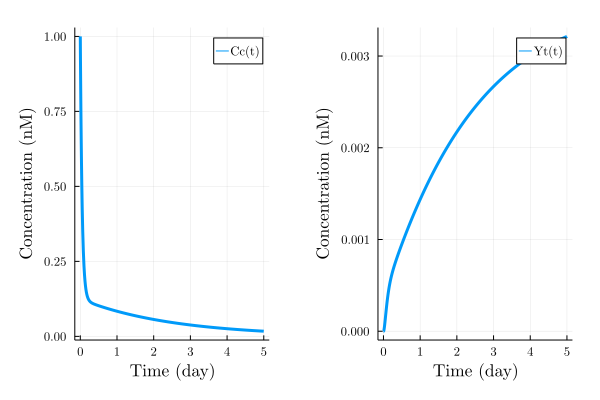

In [2]:
function model(du,u,p,t)
    Cc, Cp, Cl, T1c, D1c, T2c, D2c, Cₜ, T1ₜ, D1ₜ, T2ₜ, D2ₜ, Yₜ, X1, X2 = u
    kel,kcp,kpc,kcl,klc,Vc,Vp,Vl,kn₁,kf₁,kn₂,kf₂,kd,ks,kct,ktc,kge,kgl,kψ,kτ,kv,kmax,kc50,w = p 
    P, Rcap, Rrogh, D, Rtumor, ε =[334, 8, 75, 0.022, 1, 0.24]
    td = (2*P*Rcap/Rrogh^2 + 6*D/Rtumor^2)*(Cc-Cₜ/ε)      # tumor disposition
    du[1] = -kel*Cc -kcp*Cc +kpc*Cp*Vp/Vc -kcl*Cc +klc*Cl*Vl/Vc*kn₁/kf₁  
                -kn₁*Cc*T1c +kf₁*T1c - td*(X1+X2)/(w*Vc)               # Cc
    du[2] = +kcp*Cc*Vc/Vp -kpc*Cp                                      # Cp
    du[3] = +kcl*Cc*Vc*kn₁/(kf₁+4)/Vl -klc*Cl                          # Cp
    du[4] = -kct*T1c -ktc*T1ₜ*(X1+X2)/(w*Vc)-kn₁*Cc*T1c +kf₁*D1c        # T1c
    du[5] = +kn₁*Cc*T1c -kf₁*D1c                                       # D1c  
    du[6] = +ks -kd*T2c -kn₂*Cc*T2c +kf₂*D2c                           # T2c
    du[7] = -kel*D2c -kn₂*Cc*T2c +kf₂*D2c                              # D2c
    du[8] = +td -kn₁*T1ₜ*Cₜ -kn₂*T2ₜ*Cₜ +kf₁*D1ₜ +kf₂*D2ₜ                  # Ct
    du[9] = +kct*T1c*w*Vc/(X1+X2) -ktc*T1ₜ-kn₁*T1ₜ*Cₜ 
                                          +kf₁*D1ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Yₜ   # T1ₜ
    du[10] = +kn₁*T1ₜ*Cₜ -kf₁*D1ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Yₜ                     # D1ₜ
    du[11]= -kn₂*T2ₜ*Cₜ +kf₂*D2ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Yₜ                      # T2ₜ
    du[12]= +kn₂*T2ₜ*Cₜ -kf₂*D2ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Yₜ                      # D2ₜ
    du[13]= +kn₁*T1ₜ*D2ₜ +kn₂*T2ₜ*D1ₜ -(kf₁+kf₂)*Yₜ                       # Yₜ
    du[14]= +kge*X1*(1-(X1+X2)/kv)/(1+(kge*(X1+X2)^kψ/kgl)^(1/kψ)) 
                    - kmax*Yₜ*X1/(kc50+Yₜ)                               # X1
    du[15]= +kmax*Yₜ*X1/(kc50+Yₜ) - X2/kτ                                # X2
end

#def:  Cc, Cp, Cl, T1c, D1c, T2c,D2c, Cₜ,     T1ₜ, D1ₜ,T2ₜ, D2ₜ, Yₜ,    X1, X2
u0 = [1.0,0.0,0.0,0.83, 0.0, 1.1,0.0,0.0,1.08e-1,0.0,166,0.0,0.0,1000.0,0.0] 
#def: kel,kcp, kpc, kcl, klc,  Vc, Vp,Vl, kn₁,  kf₁, kn₂, kf₂,  kd,       ks,  kct, ktc, kge,kgl,kψ,  kτ, kv,kmax,  kc50, w 
p = [2.75, 15,2.87,0.05,0.02,40.2,211,92,1.72,19.66,1.57,0.74,2.76, 1.1*2.75, 2e-3,5e-4,0.19,123,20,3.99,1e5,1.32,6.9e-5,80] 
bis = ODEProblem(model,u0,(0.0,5.0),p)
sol = solve(bis,Tsit5(), dense=true)

p1 = plot(sol.t, sol[1,:], label="Cc(t)",
         ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3)
p2 = plot(sol.t, sol[13,:], label="Yt(t)",
         ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3)
p  = plot(p1,p2, layout=(1,2))
savefig(p, "figures/bites-1.png")
savefig(p, "figures/bites-1.pdf")
p

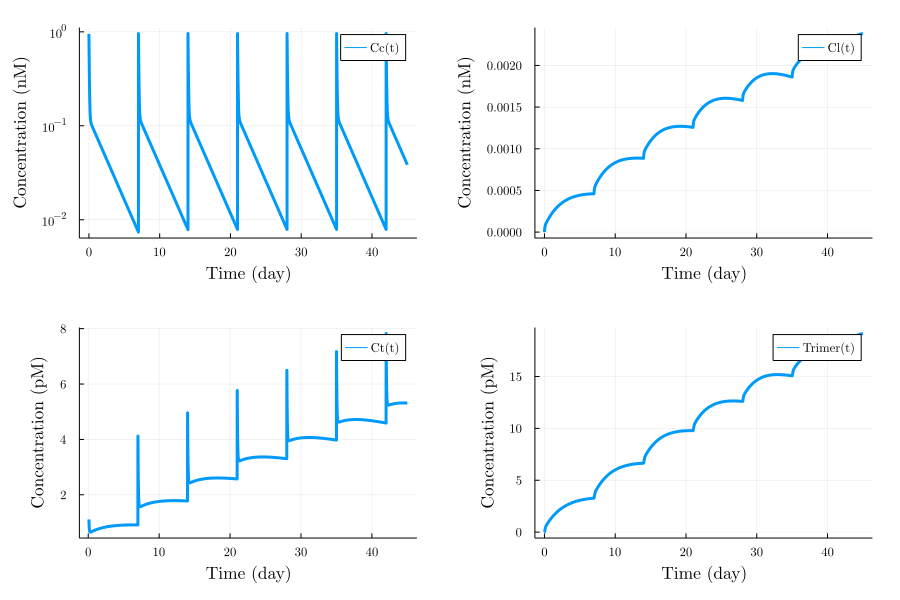

In [3]:
function weekly(dose, model)
    density = 9.52
    dosetime = [0.0, 7.0, 14.0, 21.0, 28.0, 35.0, 42.0]
    problem = remake(model; tspan=(0.0,45.0), u0=cat(density*dose, bis.u0[2:end], dims=1))
    affect!(integrator) = integrator.u[1] += density*dose
    iteration = PresetTimeCallback(dosetime,affect!)
    solution = solve(problem,Tsit5(),callback=iteration, dense=true)
    p1 = plot(solution.t, solution[1,:], label="Cc(t)", yaxis=:log,
         ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3)
    p2 = plot(solution.t, solution[3,:], label="Cl(t)",
         ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3)
    p3 = plot(solution.t[20:end], 1e3.*solution[8,20:end], label="Ct(t)",
         ylabel="Concentration (pM)", xlabel="Time (day)", linewidth=3)
    p4 = plot(solution.t, 1e3.*solution[13,:], label="Trimer(t)",
         ylabel="Concentration (pM)", xlabel="Time (day)", linewidth=3)
    p = plot(p1,p2,p3,p4, layout=(2,2), size=(900,600))
    savefig(p, "figures/bites-2.png")
    savefig(p, "figures/bites-2.pdf")
    return p
end 

weekly(0.1,bis)

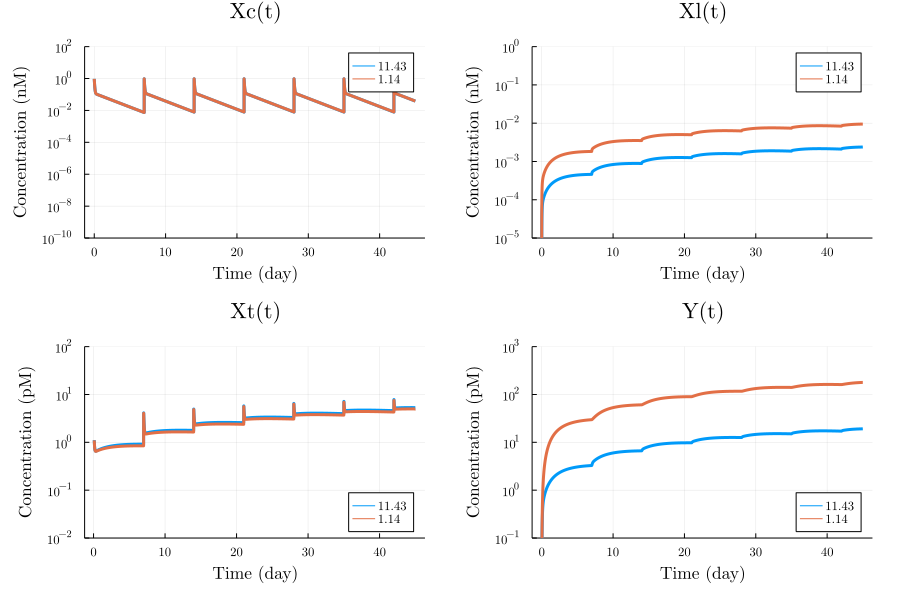

In [4]:
function comparekd(dis, model)
    density = 0.1*9.52
    dosetime = [0.0, 7.0, 14.0, 21.0, 28.0, 35.0, 42.0]
    p1 = plot(); p2=plot(); p3=plot(); p4=plot(); 
    for kd in dis
        kf = kd*1.72
        problem = remake(model; tspan=(0.0,45.0), p=cat(bis.p[1:9], kf, bis.p[11:end], dims=1)
            , u0=cat(density, bis.u0[2:end], dims=1))
        affect!(integrator) = integrator.u[1] += density
        iteration = PresetTimeCallback(dosetime,affect!)
        solution = solve(problem,Tsit5(),callback=iteration)
        p1 = plot!(p1,solution.t, solution[1,:], title="Xc(t)", yaxis=:log, label=kd,
            ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3, ylims=(1e-10,1e2))
        p2 = plot!(p2,solution.t, solution[3,:].+1e-8, title="Xl(t)", label=kd, ylims=(1e-5,1),
            ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3, yaxis=:log)
        p3 = plot!(p3,solution.t[20:end], 1e3.*solution[8,20:end].+1e-3, yaxis=:log, 
            title="Xt(t)", ylims=(1e-2,1e2), ylabel="Concentration (pM)", xlabel="Time (day)", 
            linewidth=3, label=kd, legend=:bottomright)
        p4 = plot!(p4,solution.t, 1e3.*solution[13,:].+1e-3, title="Y(t)", label=kd, ylims=(1e-1,1e3),
            ylabel="Concentration (pM)", xlabel="Time (day)", linewidth=3, yaxis=:log, legend=:bottomright)
    end
    p = plot(p1,p2,p3,p4, layout=(2,2), size=(900,600))
    savefig(p, "figures/bites-3.png")
    savefig(p, "figures/bites-3.pdf")
    return p
end 

p = comparekd([11.43, 1.14],bis)

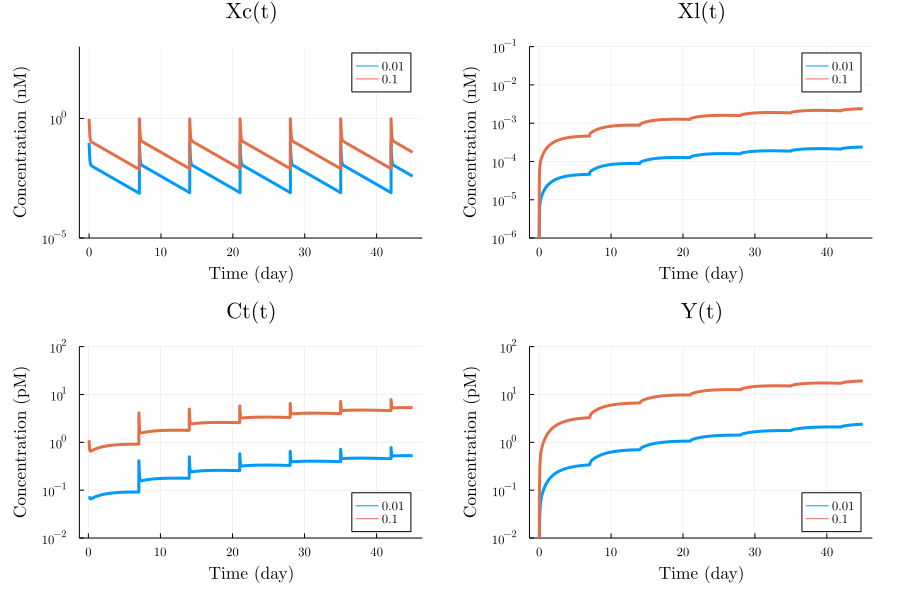

In [5]:
function comparedose(v, model)
    density = 9.52
    dosetime = [0.0, 7.0, 14.0, 21.0, 28.0, 35.0, 42.0]
    p1 = plot(); p2=plot(); p3=plot(); p4=plot(); 
    for dose in v
        problem = remake(model; tspan=(0.0,45.0), u0=cat(density*dose, bis.u0[2:end], dims=1))
        affect!(integrator) = integrator.u[1] += density*dose
        iteration = PresetTimeCallback(dosetime,affect!)
        solution = solve(problem,Tsit5(),callback=iteration)
        p1 = plot!(p1,solution.t, solution[1,:], title="Xc(t)", yaxis=:log, label=dose,
            ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3, ylims=(1e-5,1e3))
        p2 = plot!(p2,solution.t, solution[3,:].+1e-8, title="Xl(t)", label=dose, ylims=(1e-6,1e-1),
            ylabel="Concentration (nM)", xlabel="Time (day)", linewidth=3, yaxis=:log)
        p3 = plot!(p3,solution.t[20:end], 1e3.*solution[8,20:end].+1e-3, yaxis=:log, 
            title="Ct(t)", ylims=(1e-2,1e2), ylabel="Concentration (pM)", xlabel="Time (day)", 
            linewidth=3, label=dose, legend=:bottomright)
        p4 = plot!(p4,solution.t, 1e3.*solution[13,:].+1e-3, title="Y(t)", label=dose, ylims=(1e-2,1e2),
            ylabel="Concentration (pM)", xlabel="Time (day)", linewidth=3, yaxis=:log, legend=:bottomright)
    end
    p = plot(p1,p2,p3,p4, layout=(2,2), size=(900,600))
    savefig(p, "figures/bites-4.png")
    savefig(p, "figures/bites-4.pdf")
    return p
end 

p = comparedose([0.01, 0.1],bis)

# Adjourn

In [6]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2022/August/2 21:31"